In [1]:
import os 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append('../')
sys.path.append('../DeepSurvivalMachines/')
from nsc import datasets
from experiment import Experiment

In [2]:
dataset = 'FRAMINGHAM'
size = False


In [41]:
path = 'Results/'
x, t, e, covariates = datasets.load_dataset(dataset, competing = True)
competing = len(np.unique(e)) > 2

In [4]:
def concordance(risk, k, e, t, time):
    concordant, total = 0, 0
    e_, t_ = pd.Series(e, index = risk.index), pd.Series(t, index = risk.index)
    for patienti in risk[(e_ == k) & (t_ < time)].index:
        for patientj in risk[(t_ < t_.loc[patienti]) | (e_ != k)].index:
            concordant += int(risk.loc[patienti] > risk.loc[patientj])
            total += 1

    return concordant / total
 

In [51]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, integrated_brier_score

### Utils
def evaluate(survival):
    folds = survival.iloc[:, -1].values
    survival = survival.iloc[:, :-1]
    times = survival.columns.get_level_values(1).unique()
    risk = 1 - survival

    results = {}

    for r in survival.columns.get_level_values(0).unique():
        e_ = (e )#== int(r))
        for fold in np.arange(5):
            e_train, t_train = e_[folds != fold], t[folds != fold]
            e_test,  t_test  = e_[folds == fold], t[folds == fold]

            et_train = np.array([(e_train[i] != 0, t_train[i]) for i in range(len(e_train))], # TODO: CHECK IF THIS IS THE RIGHT WAY TO DO IN COMPETING RISK
                            dtype = [('e', bool), ('t', float)])
            et_test = np.array([(e_test[i] == int(r), t_test[i]) for i in range(len(e_test))],
                            dtype = [('e', bool), ('t', float)])
            selection = (t_test < t_train.max()) | (e[folds == fold] == 0)
            
            et_test = et_test[selection]
            survival_fold = survival[folds == fold][r][selection]
            risk_fold = risk[folds == fold][r][selection]

            brs = brier_score(et_train, et_test, survival_fold.values, times)[1]
            # Concordance and ROC for each time
            gcis, cis, rocs, concs = [], [], [], []
            for time in times:
                gcis.append(concordance_index_ipcw(et_train, et_test, risk_fold[time])[0])
                cis.append(concordance_index_ipcw(et_train, et_test, risk_fold[time], float(time))[0])
                rocs.append(cumulative_dynamic_auc(et_train, et_test, risk_fold[time], float(time))[0][0])

                concs.append(concordance(risk_fold[time], int(r), e[folds == fold], t[folds == fold], float(time)))

            results[(r, fold)] = pd.DataFrame.from_dict({"GCIS": gcis, "CIS": cis, "BRS": brs, "ROCS": rocs, "C-Comp": concs}, orient='index', columns = times)
    results = pd.concat(results)
    results.index.set_names(['Risk', 'Fold', 'Metric'], inplace = True)

    return results

In [52]:
# Open file
predictions, clusters, results, likelihood = {}, {}, {}, {}
for file_name in os.listdir(path):
    if dataset in file_name and '.csv' in file_name: 
        model = file_name       
        if (dataset == 'SYNTHETIC_COMPETING') and (dataset in file_name):
            model = model.replace(dataset, dataset.replace('_', ' '))
        model = model[model.index('_') + 1: model.index('.')]

        if size and model.count('_') != 1: continue
        if not size and model.count('_') == 1: continue

        print("Opening :", file_name, ' - ', model)

        if 'finegray' in model:
            # Reinitialize index
            predictions[model] = pd.read_csv(path + file_name, header = [0], index_col = 0)
            index = pd.DataFrame([[i, t] for i in ('1', '2') for t in predictions[model].columns[:3]] + [['Use', '']])
            predictions[model].columns = pd.MultiIndex.from_frame(index)
        else:
            predictions[model] = pd.read_csv(path + file_name, header = [0, 1], index_col = 0)
        results[model] = evaluate(predictions[model])

        cluster_file = file_name[: file_name.index('.')] + '_clusters.pickle'
        if os.path.isfile(path + cluster_file):
            clusters[model] = pickle.load(open(path + cluster_file, 'rb'))

        # if size:
        #     model_file = file_name[: file_name.index('.')] + '.pickle'
        #     likelihood[model] = Experiment.load(path + model_file).likelihood(x, t, e)

# Rename
if size:
    dict_name = {model: int(model[model.index('_') + 1:]) for model in results.keys()}
elif competing:
    dict_name = {'nsc': 'NSC', 'nsccs': 'NSC 1 vs Rest', 'cox': 'CoxPH CS', 'ds': 'DeepSurv 1 vs Rest', 'dsm': 'DSM 1 vs Rest', 'dcm': 'DCM 1 vs Rest', 'dh': 'DeepHit 1 vs Rest', 'finegray': 'Fine Gray'} 
else:
    dict_name = {'nsc': 'NSC', 'cox': 'CoxPH', 'ds': 'DeepSurv', 'dsm': 'DSM', 'dcm': 'DCM', 'dh': 'DeepHit'} 


likelihood = pd.DataFrame.from_dict(likelihood, 'index').rename(dict_name)
results = pd.concat(results).rename(dict_name)
results.index.set_names('Model', 0, inplace = True)

Opening : FRAMINGHAM_dsm.csv  -  dsm


In [50]:
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x: pd.Series(["{:.3f} ({:.2f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns.astype(float)))
table = table.loc[table.index.get_level_values(2).isin(["C-Comp", 'CIS', 'BRS'])].unstack(level=-1).stack(level=0).unstack(level=-1).loc[:, ["C-Comp", 'CIS', 'BRS']]
if not size:
        table = table.loc[[i for i in ['NSC', 'DCM', 'DSM', 'DeepHit', 'DeepSurv', 'NSC 1 vs Rest', 'DCM 1 vs Rest', 'DSM 1 vs Rest', 'DeepHit 1 vs Rest', 'DeepSurv 1 vs Rest', 'Fine Gray', 'CoxPH', 'CoxPH CS'] if i in table.index]]

if len(table.index.get_level_values(1).unique()) == 1:
    table = table.droplevel(1)
else:
    table = table.reorder_levels(['Risk', 'Model']).sort_index(level = 0, sort_remaining = False)

table

Metric                         C-Comp                              \
                              2153.75       4589.50       6620.75   
Risk Model                                                          
1    NSC                 0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     NSC 1 vs Rest       0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DCM 1 vs Rest       0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DSM 1 vs Rest       0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DeepHit 1 vs Rest   0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DeepSurv 1 vs Rest  0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     Fine Gray           0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     CoxPH CS            0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
2    NSC                 0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     NSC 1 vs Rest       0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DCM 1 vs Rest       0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DSM 1 vs Rest       0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DeepHit 1 vs Rest   0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     DeepSurv 1 vs Rest  0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     Fine Gray           0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   
     CoxPH CS            0.000 (0.00)  0.000 (0.00)  0.000 (0.00)   

Metric                            CIS                              \
                              2153.75       4589.50       6620.75   
Risk Model                                                          
1    NSC                 0.859 (0.03)  0.803 (0.03)  0.758 (0.03)   
     NSC 1 vs Rest       0.868 (0.03)  0.805 (0.02)  0.781 (0.01)   
     DCM 1 vs Rest       0.827 (0.09)  0.771 (0.09)  0.748 (0.08)   
     DSM 1 vs Rest       0.867 (0.03)  0.808 (0.03)  0.783 (0.02)   
     DeepHit 1 vs Rest   0.858 (0.02)  0.780 (0.03)  0.741 (0.02)   
     DeepSurv 1 vs Rest  0.869 (0.03)  0.814 (0.02)  0.788 (0.01)   
     Fine Gray           0.866 (0.02)  0.810 (0.02)  0.786 (0.01)   
     CoxPH CS            0.871 (0.03)  0.814 (0.02)  0.786 (0.01)   
2    NSC                 0.720 (0.07)  0.695 (0.03)  0.702 (0.02)   
     NSC 1 vs Rest       0.739 (0.07)  0.717 (0.02)  0.724 (0.02)   
     DCM 1 vs Rest       0.716 (0.06)  0.696 (0.02)  0.704 (0.02)   
     DSM 1 vs Rest       0.729 (0.08)  0.713 (0.03)  0.718 (0.02)   
     DeepHit 1 vs Rest   0.701 (0.07)  0.688 (0.04)  0.683 (0.02)   
     DeepSurv 1 vs Rest  0.735 (0.07)  0.708 (0.03)  0.714 (0.02)   
     Fine Gray           0.717 (0.08)  0.708 (0.02)  0.711 (0.02)   
     CoxPH CS            0.738 (0.06)  0.717 (0.02)  0.721 (0.02)   

Metric                            BRS                              
                              2153.75       4589.50       6620.75  
Risk Model                                                         
1    NSC                 0.061 (0.00)  0.105 (0.01)  0.134 (0.01)  
     NSC 1 vs Rest       0.053 (0.00)  0.094 (0.01)  0.119 (0.01)  
     DCM 1 vs Rest       0.069 (0.01)  0.108 (0.01)  0.134 (0.01)  
     DSM 1 vs Rest       0.056 (0.01)  0.099 (0.01)  0.129 (0.01)  
     DeepHit 1 vs Rest   0.050 (0.00)  0.096 (0.01)  0.129 (0.01)  
     DeepSurv 1 vs Rest  0.049 (0.01)  0.089 (0.01)  0.116 (0.01)  
     Fine Gray           0.052 (0.00)  0.091 (0.01)  0.118 (0.01)  
     CoxPH CS            0.059 (0.01)  0.098 (0.01)  0.125 (0.01)  
2    NSC                 0.025 (0.00)  0.065 (0.01)  0.099 (0.01)  
     NSC 1 vs Rest       0.025 (0.00)  0.064 (0.01)  0.095 (0.01)  
     DCM 1 vs Rest       0.025 (0.00)  0.065 (0.01)  0.097 (0.01)  
     DSM 1 vs Rest       0.025 (0.00)  0.064 (0.01)  0.096 (0.01)  
     DeepHit 1 vs Rest   0.025 (0.00)  0.064 (0.01)  0.099 (0.01)  
     DeepSurv 1 vs Rest  0.025 (0.00)  0.062 (0.01)  0.092 (0.01)  
     Fine Gray           0.025 (0.00)  0.063 (0.01)  0.096 (0.01)  
     CoxPH CS            0.025 (0.00)  0.062 (0.01)  0.091 (0.01)

In [46]:
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x: pd.Series(["{:.3f} ({:.2f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns.astype(float)))
table = table.loc[table.index.get_level_values(2).isin(["C-Comp", 'CIS', 'BRS'])].unstack(level=-1).stack(level=0).unstack(level=-1).loc[:, ["C-Comp", 'CIS', 'BRS']]
if not size:
        table = table.loc[[i for i in ['NSC', 'DCM', 'DSM', 'DeepHit', 'DeepSurv', 'NSC 1 vs Rest', 'DCM 1 vs Rest', 'DSM 1 vs Rest', 'DeepHit 1 vs Rest', 'DeepSurv 1 vs Rest', 'Fine Gray', 'CoxPH', 'CoxPH CS'] if i in table.index]]

if len(table.index.get_level_values(1).unique()) == 1:
    table = table.droplevel(1)
else:
    table = table.reorder_levels(['Risk', 'Model']).sort_index(level = 0, sort_remaining = False)

table

Metric                         C-Comp                              \
                              2153.75       4589.50       6620.75   
Risk Model                                                          
1    NSC                 0.846 (0.03)  0.771 (0.02)  0.720 (0.01)   
     NSC 1 vs Rest       0.857 (0.03)  0.776 (0.02)  0.733 (0.01)   
     DCM 1 vs Rest       0.822 (0.09)  0.746 (0.08)  0.702 (0.06)   
     DSM 1 vs Rest       0.852 (0.02)  0.774 (0.02)  0.727 (0.01)   
     DeepHit 1 vs Rest   0.848 (0.02)  0.756 (0.02)  0.705 (0.02)   
     DeepSurv 1 vs Rest  0.861 (0.03)  0.784 (0.02)  0.733 (0.01)   
     Fine Gray           0.860 (0.02)  0.783 (0.02)  0.736 (0.01)   
     CoxPH CS            0.859 (0.03)  0.781 (0.02)  0.731 (0.01)   
2    NSC                 0.707 (0.06)  0.667 (0.02)  0.654 (0.02)   
     NSC 1 vs Rest       0.734 (0.06)  0.696 (0.02)  0.683 (0.02)   
     DCM 1 vs Rest       0.715 (0.05)  0.679 (0.01)  0.667 (0.02)   
     DSM 1 vs Rest       0.726 (0.07)  0.690 (0.02)  0.674 (0.01)   
     DeepHit 1 vs Rest   0.696 (0.05)  0.673 (0.02)  0.651 (0.01)   
     DeepSurv 1 vs Rest  0.734 (0.06)  0.690 (0.02)  0.677 (0.02)   
     Fine Gray           0.742 (0.07)  0.716 (0.02)  0.699 (0.02)   
     CoxPH CS            0.734 (0.05)  0.696 (0.02)  0.679 (0.02)   

Metric                            CIS                              \
                              2153.75       4589.50       6620.75   
Risk Model                                                          
1    NSC                 0.857 (0.03)  0.799 (0.03)  0.753 (0.03)   
     NSC 1 vs Rest       0.867 (0.03)  0.801 (0.02)  0.775 (0.01)   
     DCM 1 vs Rest       0.826 (0.09)  0.767 (0.09)  0.742 (0.08)   
     DSM 1 vs Rest       0.865 (0.03)  0.803 (0.03)  0.775 (0.02)   
     DeepHit 1 vs Rest   0.856 (0.02)  0.777 (0.03)  0.736 (0.02)   
     DeepSurv 1 vs Rest  0.868 (0.03)  0.810 (0.02)  0.780 (0.01)   
     Fine Gray           0.865 (0.02)  0.806 (0.02)  0.780 (0.01)   
     CoxPH CS            0.869 (0.03)  0.809 (0.02)  0.779 (0.01)   
2    NSC                 0.720 (0.07)  0.695 (0.03)  0.703 (0.02)   
     NSC 1 vs Rest       0.739 (0.07)  0.716 (0.02)  0.724 (0.02)   
     DCM 1 vs Rest       0.716 (0.06)  0.696 (0.02)  0.705 (0.02)   
     DSM 1 vs Rest       0.728 (0.08)  0.712 (0.02)  0.717 (0.02)   
     DeepHit 1 vs Rest   0.700 (0.06)  0.687 (0.03)  0.683 (0.02)   
     DeepSurv 1 vs Rest  0.735 (0.07)  0.708 (0.02)  0.715 (0.02)   
     Fine Gray           0.717 (0.08)  0.708 (0.02)  0.711 (0.02)   
     CoxPH CS            0.737 (0.06)  0.717 (0.02)  0.721 (0.02)   

Metric                            BRS                              
                              2153.75       4589.50       6620.75  
Risk Model                                                         
1    NSC                 0.062 (0.00)  0.109 (0.01)  0.144 (0.01)  
     NSC 1 vs Rest       0.053 (0.00)  0.099 (0.01)  0.131 (0.01)  
     DCM 1 vs Rest       0.069 (0.01)  0.112 (0.01)  0.145 (0.01)  
     DSM 1 vs Rest       0.057 (0.01)  0.103 (0.01)  0.139 (0.01)  
     DeepHit 1 vs Rest   0.051 (0.00)  0.101 (0.01)  0.141 (0.01)  
     DeepSurv 1 vs Rest  0.050 (0.01)  0.093 (0.01)  0.127 (0.01)  
     Fine Gray           0.052 (0.01)  0.095 (0.01)  0.128 (0.01)  
     CoxPH CS            0.060 (0.01)  0.102 (0.01)  0.136 (0.01)  
2    NSC                 0.027 (0.00)  0.073 (0.01)  0.116 (0.01)  
     NSC 1 vs Rest       0.027 (0.00)  0.071 (0.01)  0.111 (0.01)  
     DCM 1 vs Rest       0.027 (0.00)  0.072 (0.01)  0.114 (0.01)  
     DSM 1 vs Rest       0.027 (0.00)  0.071 (0.01)  0.113 (0.01)  
     DeepHit 1 vs Rest   0.027 (0.00)  0.072 (0.01)  0.116 (0.01)  
     DeepSurv 1 vs Rest  0.026 (0.00)  0.070 (0.01)  0.109 (0.01)  
     Fine Gray           0.027 (0.00)  0.071 (0.01)  0.112 (0.01)  
     CoxPH CS            0.026 (0.00)  0.069 (0.01)  0.108 (0.01)

In [ ]:
print(table.to_latex())

\begin{tabular}{lllllllllll}
\toprule
  & Metric & \multicolumn{3}{l}{C-Comp} & \multicolumn{3}{l}{CIS} & \multicolumn{3}{l}{BRS} \\
  & {} &       2153.75 &       4589.50 &       6620.75 &       2153.75 &       4589.50 &       6620.75 &       2153.75 &       4589.50 &       6620.75 \\
Risk & Model &               &               &               &               &               &               &               &               &               \\
\midrule
1 & NSC &  0.000 (0.00) &  0.000 (0.00) &  0.000 (0.00) &  0.857 (0.03) &  0.799 (0.03) &  0.753 (0.03) &  0.062 (0.00) &  0.109 (0.01) &  0.144 (0.01) \\
  & NSC CS &  0.000 (0.00) &  0.000 (0.00) &  0.000 (0.00) &  0.867 (0.03) &  0.801 (0.02) &  0.775 (0.01) &  0.053 (0.00) &  0.099 (0.01) &  0.131 (0.01) \\
  & DCM &  0.000 (0.00) &  0.000 (0.00) &  0.000 (0.00) &  0.826 (0.09) &  0.767 (0.09) &  0.742 (0.08) &  0.069 (0.01) &  0.112 (0.01) &  0.145 (0.01) \\
  & DSM &  0.000 (0.00) &  0.000 (0.00) &  0.000 (0.00) &  0.865 (0.03) &  0

---------

# Analysis cluster

In [30]:
method_display = 'nsc'

0


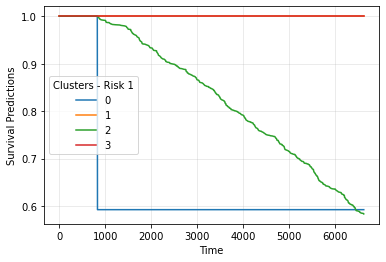

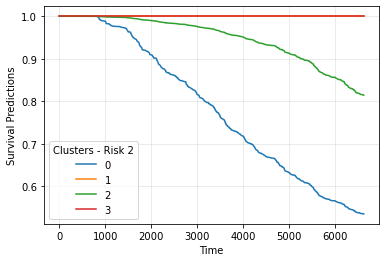

1


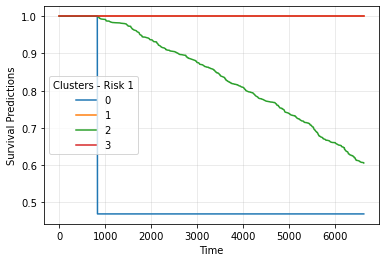

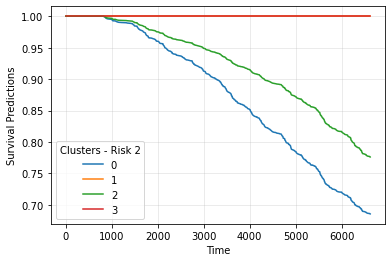

2


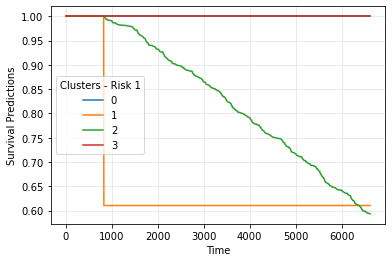

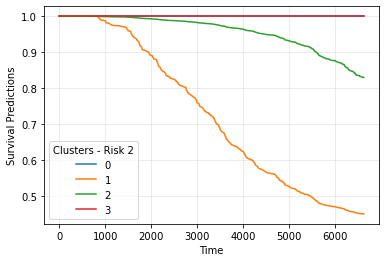

3


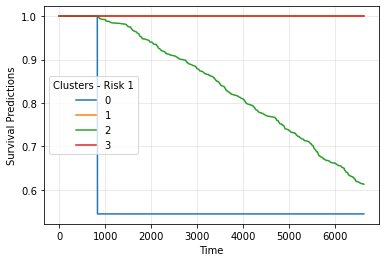

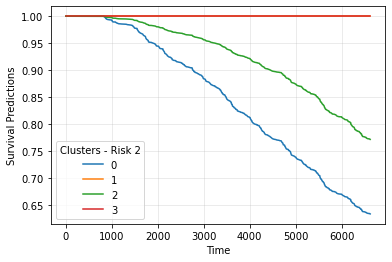

4


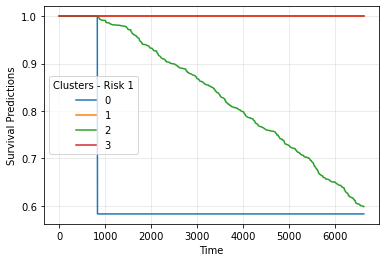

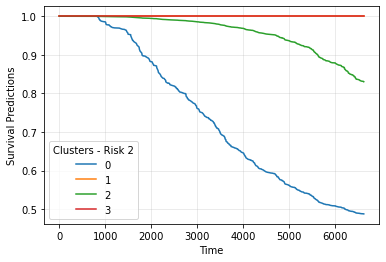

In [31]:
for i in np.arange(5):
    print(i)
    if 'predictions' not in clusters[method_display][i]:
        horizons_pred = np.linspace(0, 0.75, clusters[method_display][i][1]['predictions'].shape[0])
        for risk in clusters[method_display][i]:
            pd.DataFrame(clusters[method_display][i][risk]['predictions'], index = np.quantile(t[e!= 0], horizons_pred)).plot()
            plt.xlabel('Time')
            plt.ylabel('Survival Predictions')
            plt.grid(alpha = 0.3)
            plt.legend(title = 'Clusters - Risk {}'.format(risk))
            plt.show()
    else:
        horizons_pred = np.linspace(0, 0.75, clusters[method_display][i]['predictions'].shape[0])
        pd.DataFrame(clusters[method_display][i]['predictions'], index = np.quantile(t[e==1], horizons_pred)).plot()
        plt.xlabel('Time')
        plt.ylabel('Survival Predictions')
        plt.grid(alpha = 0.3)
        plt.legend(title = 'Clusters')
        plt.show()

In [11]:
models = [method_display]


KeyError: 'predictions'

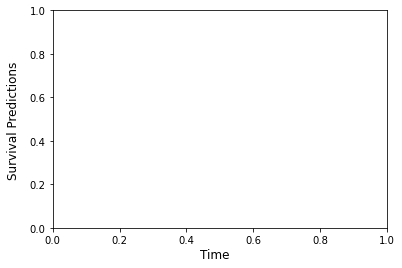

In [12]:
horizons_pred = np.linspace(0, 0.75, 10)
fig, ax = plt.subplots(nrows = 1, ncols = len(models), figsize = (len(models) * 6, 4), sharey = True)
if len(models) == 1:
    ax = [ax]
fig.supylabel('Survival Predictions')
fig.supxlabel('Time')

# Baseline
for i, method in enumerate(models):
    ordered_cluster = []
    for j in clusters[method]:
        order = np.argsort(clusters[method][j]['predictions'][-1])
        ordered_cluster.append(clusters[method][j]['predictions'][:, order])
    mean = pd.DataFrame(np.mean(ordered_cluster, 0), index = np.quantile(t[e==1], horizons_pred))
    std = 1.96 * pd.DataFrame(np.std(ordered_cluster, 0), index = np.quantile(t[e==1], horizons_pred)) / np.sqrt(len(mean.columns))
    mean.plot(ax = ax[i], legend = False)
    for k in mean.columns:
        ax[i].fill_between(mean.index, mean[k] + std[k], mean[k] - std[k], alpha = 0.5)

    ax[i].grid(alpha = 0.3)
    ax[i].legend(title = 'Clusters', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.ylim(-0.05, 1.05)

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

In [ ]:
# Compute average life expectancy for each cluster
clusters_expectancy, clusters_assignments = [], []
for fold in clusters[method_display]:
    index = clusters[method_display][fold]['alphas_test'].index
    order = np.argsort(clusters[method_display][fold]['predictions'][-1]) # Reorder cluster
    clusters_assignment = np.argmax(clusters[method_display][fold]['alphas_test'].iloc[:, order].values, axis = 1)
    clusters_assignment = pd.DataFrame({'Assignment': clusters_assignment, 'Event': e[index], 'Time': t[index]}, index = index)
    clusters_assignments.append(clusters_assignment)
    clusters_expectancy.append(clusters_assignment.groupby('Assignment').apply(lambda x: KaplanMeierFitter().fit(x['Time'], x['Event']).median_survival_time_))
    print(multivariate_logrank_test(clusters_assignment['Time'], clusters_assignment['Assignment'], clusters_assignment['Event']))
clusters_assignments = pd.concat(clusters_assignments, 0)
clusters_expectancy = pd.concat(clusters_expectancy, 1).replace([np.inf, -np.inf], np.nan)

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          37.14 <0.005     26.79
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          58.02 <0.005     41.85
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          11.76 <0.005      8.49
<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          18.

/tmp/ipykernel_25672/2173491133.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  clusters_assignments = pd.concat(clusters_assignments, 0)
/tmp/ipykernel_25672/2173491133.py:12: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  clusters_expectancy = pd.concat(clusters_expectancy, 1).replace([np.inf, -np.inf], np.nan)


In [ ]:
print("Survival")
clusters_expectancy.mean(1), clusters_expectancy.std(1)

Survival


(Assignment
 0    102.220000
 1    135.746666
 2    237.816666
 dtype: float64,
 Assignment
 0    31.506107
 1    13.535111
 2    35.538426
 dtype: float64)

In [ ]:
print("Characteristics Clusters")
pd.concat([pd.DataFrame(x, columns = covariates), clusters_assignments], axis = 1).groupby('Assignment').mean()

Characteristics Clusters


,MKI67,EGFR,PGR,ERBB2,Hormone,Radiotherapy,Chemotherapy,ER-positive,Age at diagnosis,Event,Time
Assignment,,,,,,,,,,,
0,0.502682,-0.639135,0.692626,0.724874,-0.145088,0.150649,0.762719,-0.810429,0.008395,0.664474,104.358480
1,-0.354590,0.222466,-0.228492,-0.225372,0.273172,-0.209986,-0.506701,0.440985,0.605579,0.664336,125.921873
2,0.127144,0.170457,-0.203036,-0.232497,-0.285122,0.188935,0.147373,-0.014930,-0.887145,0.389831,142.921017


In [ ]:
print("Percentage Population")
clusters_assignments.groupby('Assignment').size() * 100 / len(clusters_assignments)

Percentage Population


Assignment
0    23.949580
1    45.063025
2    30.987395
dtype: float64

In [ ]:
print("Censored")
(1 - clusters_assignments.groupby('Assignment').mean()['Event']) * 100

Censored


Assignment
0    33.552632
1    33.566434
2    61.016949
Name: Event, dtype: float64

In [ ]:
print("Difference in Survival")
multivariate_logrank_test(clusters_assignments['Time'], clusters_assignments['Assignment'], clusters_assignments['Event']).summary

Difference in Survival


,test_statistic,p,-log2(p)
0,127.126068,2.482705e-28,91.702074


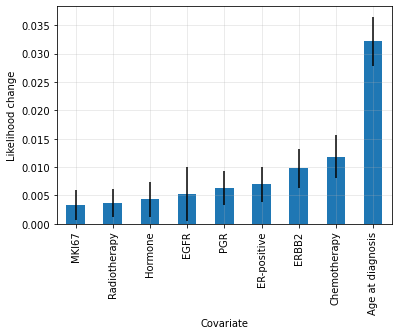

In [ ]:
# Display importance
importance = []
for j in clusters[method]:
    importance.append(pd.Series(clusters[method][j]['importance'][0]))

importance = - pd.concat(importance, axis = 1)
importance.index = covariates
importance.mean(1).sort_values().plot.bar(yerr = importance.std(1))
plt.xlabel('Covariate')
plt.ylabel('Likelihood change')
plt.grid(alpha = 0.3)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
for i in clusters[method_display]:
    tsne = TSNE(n_components = 2, random_state=0)
    tsne = pd.DataFrame(tsne.fit_transform(clusters[method_display][i]['alphas_train']), columns = ['Projection 1', 'Projection 2'], index = clusters[method_display][i]['alphas_train'].index)
    tsne['Survival time'] = (t[tsne.index]) #np.digitize(t[tsne.index], [0,100,200,400])
    tsne.plot.scatter('Projection 1', 'Projection 2', c = 'Survival time', cmap='viridis', alpha = 0.5)
    plt.show()

----------

# Analysis number components

In [ ]:
mean = results.groupby(['Model', 'Risk', 'Metric']).mean()
mean = mean[(mean.index.get_level_values('Risk') == '1') & (mean.index.get_level_values('Metric') == 'CIS')].droplevel(['Risk', 'Metric'])
std = results.groupby(['Model', 'Risk', 'Metric']).std()
std = std[(std.index.get_level_values('Risk') == '1') & (std.index.get_level_values('Metric') == 'CIS')].droplevel(['Risk', 'Metric'])
ci = 1.96 * std / np.sqrt(len(results.index.get_level_values('Fold').unique()))
mean.columns = ['0.25', '0.5', '0.75']
ci.columns = ['0.25', '0.5', '0.75']
mean.plot()
for i in mean.columns:
    plt.fill_between(mean[i].index, mean[i] + ci[i], mean[i] - ci[i], alpha = 0.5)

plt.grid(alpha = .3)
plt.xlabel('Number cluster')
plt.ylabel('C Index')

In [ ]:
# Compute likelihood
mean = likelihood.sort_index().mean(1)
std = 1.96 * likelihood.sort_index().std(1) / np.sqrt(5)

mean.plot()
plt.fill_between(std.index, mean + std, mean - std, alpha = 0.3)
#plt.legend(title = 'Fold', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(alpha = .3)
plt.xlabel('Number cluster')
plt.ylabel('Negative Log Likelihood')